In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

## I. DATA PREPARATION

### Function to clean product data scraping from web including review and review times (as image) 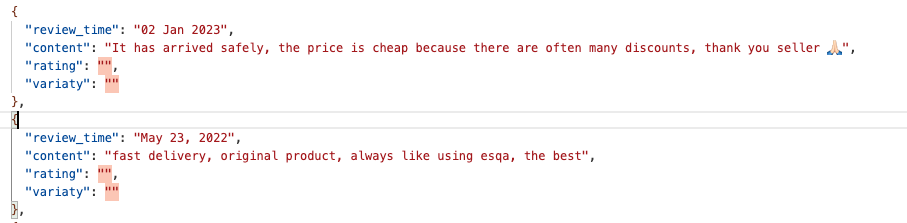

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [122]:
current_date = datetime.strptime('10-06-2025', '%d-%m-%Y').date()
begin_year = datetime.strptime('01-01-2025', '%d-%m-%Y').date()
dct = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [5]:
with open('lzd_detail_review_ESQA_Flawless_Cushion_Serum_SPF_50Satin_20250610_133244.json', 'r') as file:
    data = json.load(file)


In [9]:
def clean_week(string):
    week = int(string.split()[0])
    exact_date = current_date - timedelta(weeks=week)
    return exact_date

In [10]:
def clean_day(string):
    day = int(string.split()[0])
    exact_date = current_date - timedelta(days=day)
    return exact_date

In [12]:
def time_process(string):
    dct = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    string = string.replace(',', '')
    m, d, y = string.split()
    # print(m, d, y)
    if len(m) ==3:
        month = dct[m]
        fix_date = f'{d}-{month}-{y}'
    else:
        month = dct[d]
        fix_date = f'{m}-{month}-{y}'
    fix_date = datetime.strptime(fix_date, '%d-%m-%Y')
    fix_date = fix_date.date()
    return fix_date


In [13]:
def cleaning_all(data):
    ls = []
    for element in data:
        for e in element:
            ls.append(e)
    df = pd.DataFrame(ls)
    df = df[df['review_time'] != '']
    df_week = df[df['review_time'].str.contains('week', case=False)]
    df_week['fix_review_time'] = df_week['review_time'].apply(clean_week)
    df_day = df[df['review_time'].str.contains('day', case=False)]
    df_day['fix_review_time'] = df_day['review_time'].apply(clean_day)
    df_other_date = df[~((df['review_time'].str.contains('week', case=False, na=False)) | (df['review_time'].str.contains('day', case=False, na=False)))]
    df_other_date['fix_review_time'] = df_other_date['review_time'].apply(time_process)
    df_final = pd.concat([df_day, df_week, df_other_date], axis=0, ignore_index=True)
    df_final.drop_duplicates(subset=['content', 'review_time'], inplace=True)
    return df_final

### Cleaning from list of all data with name, amount sold, price and the earliest of review time (as image)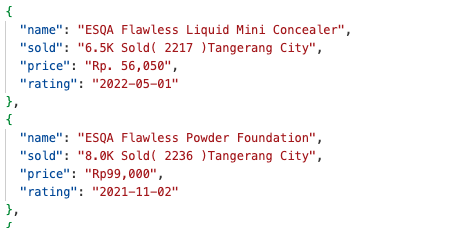

In [68]:
with open('scraped_page_20250610_143619.json', 'r') as file:
    data_all = json.load(file)

In [69]:
df2 = pd.DataFrame(data_all)

In [31]:
df2.head(5)

,name,sold,price,rating
0,ESQA Minimalist Blurring Serum Skin Tint SPF 3...,349 Sold( 106 )Tangerang City,"Rp119,000",2023-05-09
1,ESQA Goddess Eyeshadow Palette,2.6K Sold( 726 )Tangerang City,"Rp135,000",2022-04-08
2,ESQA Flawless Cushion Serum SPF 50+ PA+++ - Satin,4.6K Sold( 1351 )Tangerang City,"Rp101,500",2022-07-13
3,ESQA Bronzer,465 Sold( 118 )Tangerang City,"Rp. 79,000",2022-05-29
4,ESQA Trio Goddess Cheek Palette,2.0K Sold( 553 )Tangerang City,"Rp. 155,000",2021-11-17


In [123]:
#use regex to separate the number of product sold, number of review from sold column, and get the price from price column
df2['sold_num'] = df2['sold'].str.extract(r'(\d+\.?\d*)')[0].astype(float) * df2['sold'].str.contains('[kK]').map({True: 1000, False: 1})
df2['no_review'] = df2['sold'].apply(
    lambda x: float(x.split('(')[1].split(')')[0]) if '(' in x else np.nan
)
df2['price_num'] = df2['price'].str.replace('Rp', '').str.replace(',', '').str.replace('.', '').astype(float)


In [124]:
#create more columns to further calculation
df2['review_time'] = pd.to_datetime(df2['rating'])
df2['days_since_review'] = (pd.to_datetime(current_date) - df2['review_time']).dt.days
df2['month_on_site'] = round(df2['days_since_review']/30.0, 2)
df2['avg_sold_per_month'] = round(df2['sold_num']/df2['month_on_site'], 2)

In [84]:
df2.head()

,name,sold,price,rating,sold_num,no_review,price_num,review_time,days_since_review,month_on_site,avg_sold_per_month
0,ESQA Minimalist Blurring Serum Skin Tint SPF 3...,349 Sold( 106 )Tangerang City,"Rp119,000",2023-05-09,349.0,106.0,119000.0,2023-05-09,763,25.43,13.72
1,ESQA Goddess Eyeshadow Palette,2.6K Sold( 726 )Tangerang City,"Rp135,000",2022-04-08,2600.0,726.0,135000.0,2022-04-08,1159,38.63,67.31
2,ESQA Flawless Cushion Serum SPF 50+ PA+++ - Satin,4.6K Sold( 1351 )Tangerang City,"Rp101,500",2022-07-13,4600.0,1351.0,101500.0,2022-07-13,1063,35.43,129.83
3,ESQA Bronzer,465 Sold( 118 )Tangerang City,"Rp. 79,000",2022-05-29,465.0,118.0,79000.0,2022-05-29,1108,36.93,12.59
4,ESQA Trio Goddess Cheek Palette,2.0K Sold( 553 )Tangerang City,"Rp. 155,000",2021-11-17,2000.0,553.0,155000.0,2021-11-17,1301,43.37,46.11


In [85]:
df2_clean = df2.dropna()

## II. DATA VISUALIZATION

**Assumption:** As we can only see the sales of all times of each product, and dont know when the product started to sell. I assume the day of first reviewer to be the day the product start being sold on app. <br>
The following scatter chart represent the number of items sold in each products, along with duration of the first review to current day (2025-06-10) and the price of each item <br> We can see that the 5 best sellers of Esqa is generally of the medium price range and have been on site for more than 3 years (30-40 months)

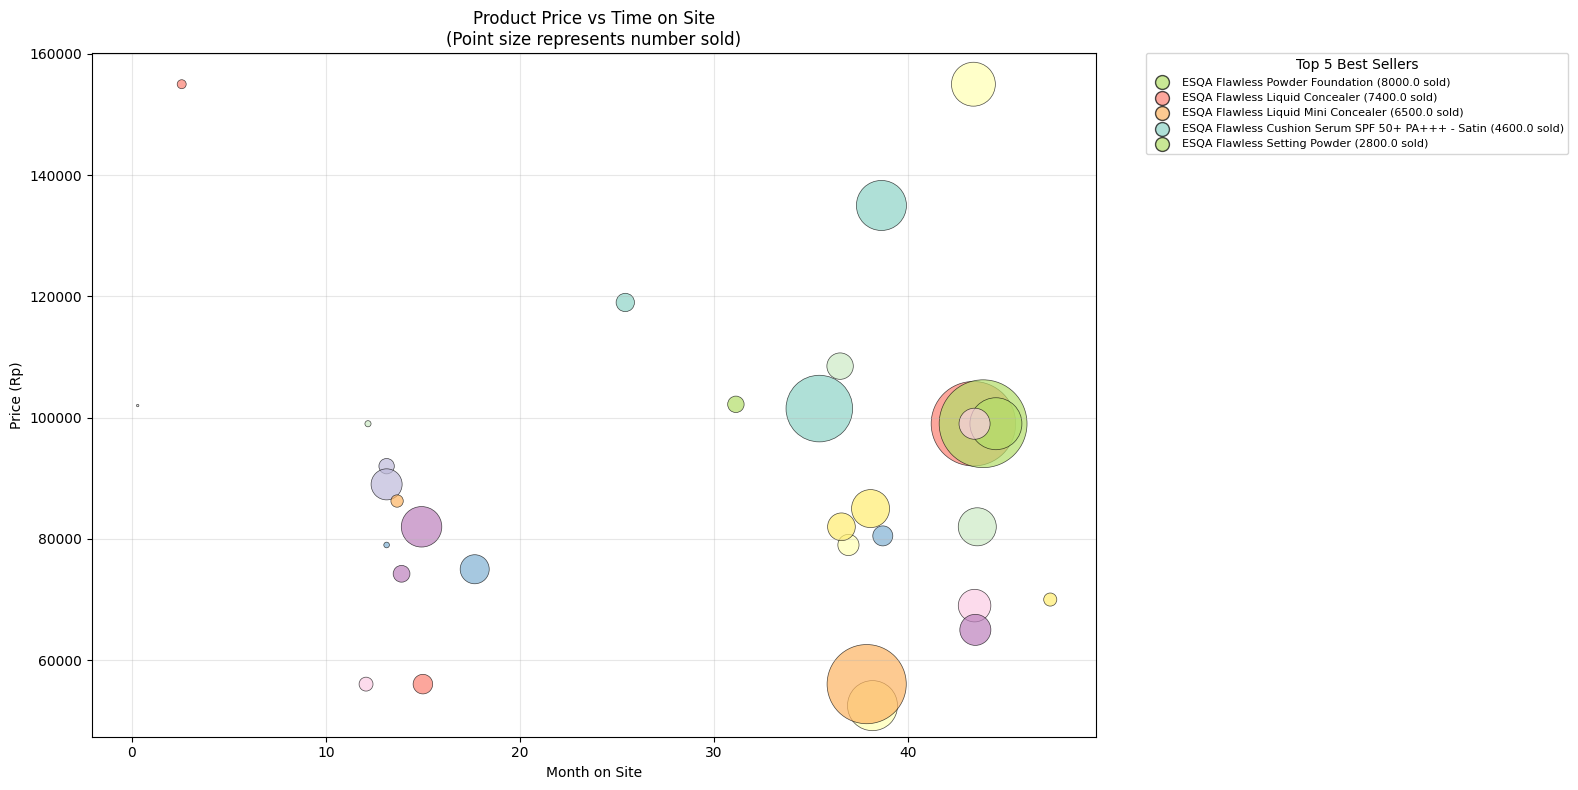

Data Summary:
Month on site range: 0.3 - 47.3
Price range: Rp52,500 - Rp165,000
Sold quantity range: 6.0 - 8000.0


In [125]:

plt.figure(figsize=(16, 8))


colors = plt.cm.Set3(np.linspace(0, 1, len(df2)))

# Get top 5 products by sold_num for legend
top5_products = df2.nlargest(5, 'sold_num')
top5_indices = top5_products.index.tolist()

# Create scatter plot with different colors for each product
scatter = plt.scatter(df2['month_on_site'], df2['price_num'], 
                     s=df2['sold_num']/2,  # Scale down the size for better visualization
                     alpha=0.7, 
                     c=colors,
                     edgecolors='black',
                     linewidth=0.5)

# Add labels and title
plt.xlabel('Month on Site')
plt.ylabel('Price (Rp)')
plt.title('Product Price vs Time on Site\n(Point size represents number sold)')

# Format y-axis to show price in a readable format
plt.ticklabel_format(style='plain', axis='y')


plt.grid(True, alpha=0.3)

# Create legend for top 5 products by sold_num
legend_elements = []
legend_labels = []

for i, idx in enumerate(top5_indices):
    # Create a scatter point for legend with the same color as in the plot
    legend_point = plt.scatter([], [], c=[colors[idx]], s=100, alpha=0.7, edgecolors='black')
    legend_elements.append(legend_point)
    
    # Keep full product names without truncation
    product_name = df2.loc[idx, 'name']
    sold_count = df2.loc[idx, 'sold_num']
    legend_labels.append(f'{product_name} ({sold_count} sold)')

# Add legend with top 5 products
plt.legend(legend_elements, legend_labels, 
          title='Top 5 Best Sellers', 
          bbox_to_anchor=(1.05, 1), loc='upper left', 
          borderaxespad=0, fontsize=8)

plt.tight_layout()
plt.show()


print("Data Summary:")
print(f"Month on site range: {df2['month_on_site'].min():.1f} - {df2['month_on_site'].max():.1f}")
print(f"Price range: Rp{df2['price_num'].min():,.0f} - Rp{df2['price_num'].max():,.0f}")
print(f"Sold quantity range: {df2['sold_num'].min()} - {df2['sold_num'].max()}")

### The bar chart represent the total number of quantity sold by each product. The 5 best sellers is in the blue and on the left side

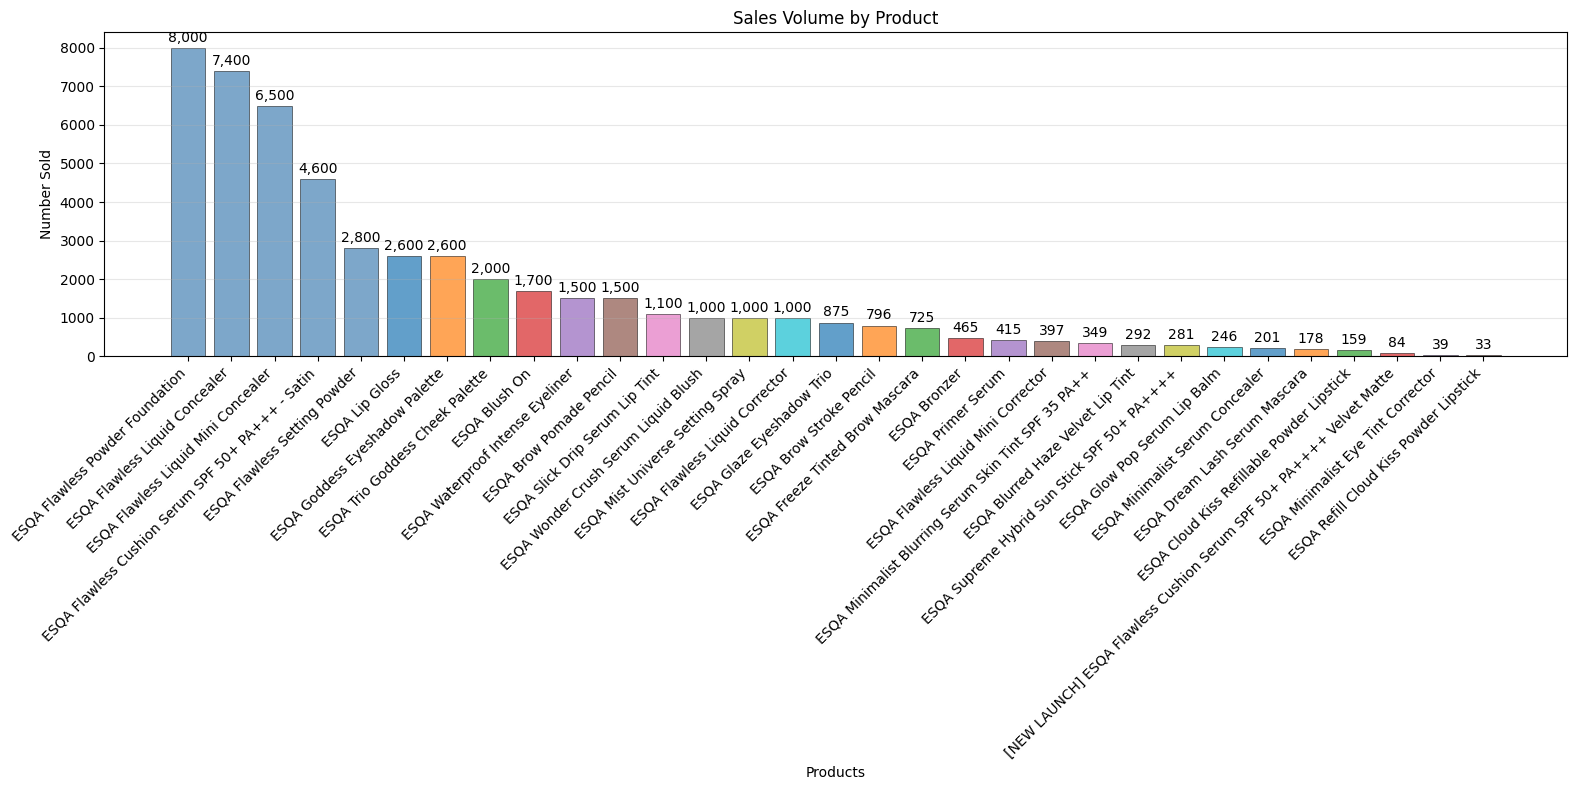

Sales Summary:
Total products: 33
Total units sold: 50,835.0
Average units sold per product: 1639.8
Best seller: ESQA Flawless Powder Foundation (8000.0 sold)
Lowest seller: ESQA Refill Cloud Kiss Powder Lipstick (33.0 sold)


In [126]:

plt.figure(figsize=(16, 8))


df2_sorted = df2_clean.sort_values('sold_num', ascending=False)

product_names = df2_sorted['name']
sold_numbers = df2_sorted['sold_num']


colors = []
for i in range(len(product_names)):
    if i < 5:  
        colors.append('steelblue')
    else:  
        colors.append(plt.cm.tab10((i-5) % 10))

bars = plt.bar(range(len(product_names)), sold_numbers, 
               color=colors,
               alpha=0.7,
               edgecolor='black',
               linewidth=0.5)

for i, (bar, sold_num) in enumerate(zip(bars, sold_numbers)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sold_numbers)*0.01,
             f'{int(sold_num):,}', ha='center', va='bottom', fontweight='normal', fontsize=10)

plt.xticks(range(len(product_names)), product_names, rotation=45, ha='right')

plt.xlabel('Products')
plt.ylabel('Number Sold')
plt.title('Sales Volume by Product')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print summary statistics
print("Sales Summary:")
print(f"Total products: {len(df2)}")
print(f"Total units sold: {sold_numbers.sum():,}")
print(f"Average units sold per product: {sold_numbers.mean():.1f}")
print(f"Best seller: {product_names[sold_numbers.idxmax()]} ({sold_numbers.max()} sold)")
print(f"Lowest seller: {product_names[sold_numbers.idxmin()]} ({sold_numbers.min()} sold)")

### I suspect that there is a relationship between the number of reviews and number of product sold
From a simple linear regression model with $R^2 = 0.989$ and the visualisation below, I can conclude that there is a positive correlation between these two figures. I would use this insight to work out the YTD sales later

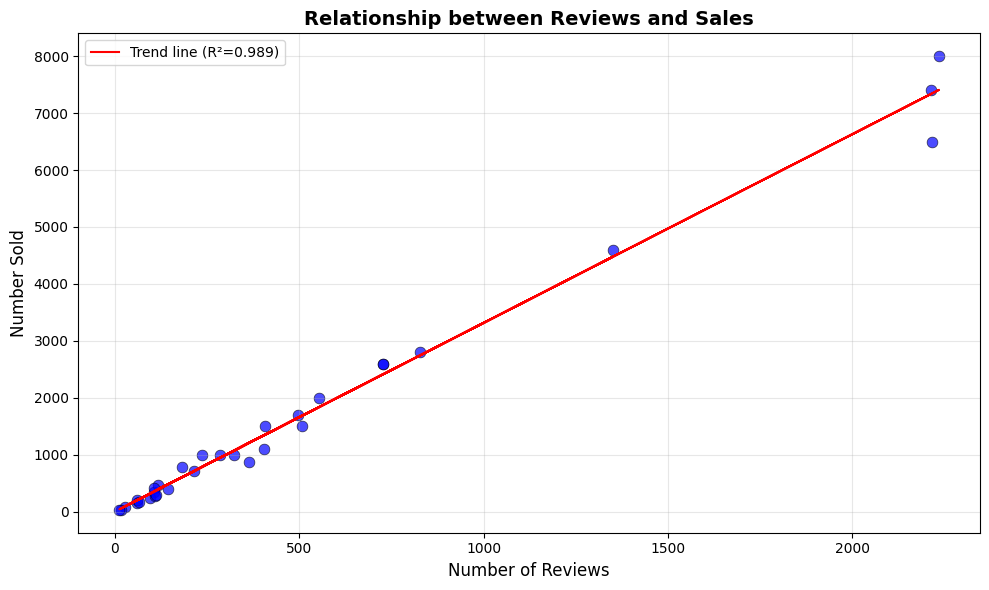

In [127]:
plt.figure(figsize=(10, 6))
plt.scatter(df2_clean['no_review'], df2_clean['sold_num'], alpha=0.7, s=60, c='blue', edgecolors='black', linewidth=0.5)

# Customize the plot
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Number Sold', fontsize=12)
plt.title('Relationship between Reviews and Sales', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add some styling
plt.tight_layout()

# Optional: Add trend line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df2_clean['no_review'], df2_clean['sold_num'])
line = slope * df2_clean['no_review'] + intercept
plt.plot(df2_clean['no_review'], line, 'r', label=f'Trend line (R²={r_value**2:.3f})')
plt.legend()

plt.show()

# III. ESTIMATE YEAR-TO-DATE SALES OF 5 BEST SELLER

What the platform have: 
* Listing of all products with total sales, total review, total rating and current price
* Detail of each products: variation, usage guideline, expiration date
* Overall statistic of the shop: number of followers, respond rate, current promotion programs <br> <br>


What we have to calculate: The YTD sales of 5 best seller <br>
Challenges: We dont have the time log of product sold, dont know the trend of selling and the time product started being sold

**Solution** As we work out earlier, there is a relationship between review and sales volume. I would assume that there is also a relationship between the number of review and sale volume in the lifespan of the product. In other words, I would assume that the number of product sold in a period of time correlate with the ratio of review in that period compare to the total reviews. 
<br> Then, I would crawl all review data of each product on website and calculate the number of review they have to calculate the total sale

In [134]:
#loading review data of product
with open('lzd_detail_review_ESQA_Goddess_Eyeshadow_Palette_20250610_233738.json', 'r') as file:
    goddess_eyeshadow = json.load(file)
df_goddess_eyeshadow = cleaning_all(goddess_eyeshadow)

In [135]:
df_goddess_eyeshadow

,review_time,content,rating,variaty,fix_review_time
0,1 day ago,"Easy to apply and blend, Beautiful metallic lo...",,,2025-06-09
1,1 week ago,So happy to hear that my order has arrived 🥰 H...,,,2025-06-03
2,2 weeks ago,"Beautiful metallic look, Versatile palette for...",,,2025-05-27
3,4 weeks ago,"Impressive durability, Ideal for everyday wear,",,,2025-05-13
4,02 Dec 2024,"Pigmentation: Beautiful peach shades, Great va...",,,2024-12-02
...,...,...,...,...,...
228,09 Jul 2024,Quality: good,,,2024-07-09
229,"Oct 12, 2024",order not correct,,,2024-10-12
230,22 Jun 2023,disappointed that the item is broken,,,2023-06-22
231,"Apr 15, 2022",ok,,,2022-04-15


In [136]:

#function to visualise review count by time and calculate the review ratio and estimate the ytd sale
def analyze_monthly_reviews(df, total_sale,review_time_col='fix_review_time', product_name=None):
    """
    Analyze and visualize monthly review patterns for a product dataframe.
    
    Parameters:
    df (DataFrame): Input dataframe containing review data
    review_time_col (str): Column name containing review timestamps
    product_name (str): Name of the product for the title (optional)
    
    Returns:
    dict: Summary statistics of the review analysis
    """
    
    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Create month start column for grouping
    df_copy['month_start'] = (pd.to_datetime(df_copy[review_time_col])
                             .dt.to_period('M')
                             .dt.to_timestamp())
    
    # Count reviews by month
    count_review = df_copy.groupby('month_start')[review_time_col].count()
    
    # Create a prettier plot
    plt.figure(figsize=(14, 8))
    
    # Plot the line with better styling
    plt.plot(count_review.index, count_review.values, 
             marker='o', linewidth=2.5, markersize=6, 
             color='steelblue', markerfacecolor='lightblue', 
             markeredgecolor='steelblue', markeredgewidth=1.5)
    
    # Fill area under the curve
    plt.fill_between(count_review.index, count_review.values, 
                    alpha=0.3, color='steelblue')
    
    # Customize the plot
    title = f'{product_name} - Monthly Review Count' if product_name else 'Monthly Review Count'
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Month', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Reviews', fontsize=12, fontweight='bold')
    
    # Format x-axis
    plt.xticks(rotation=45, ha='right')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Improve layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Calculate reviews from 2025-01-01 onwards
    begin_2025 = pd.to_datetime('2025-01-01')
    reviews_from_2025 = len(df_copy[pd.to_datetime(df_copy[review_time_col]) >= begin_2025])
    total_reviews = len(df_copy)
    ratio_2025 = reviews_from_2025 / total_reviews if total_reviews > 0 else 0
    sale_2025 = round(ratio_2025*total_sale, 0)
    
    # Create summary statistics dictionary
    summary_stats = {
        'total_reviews': total_reviews,
        'review_period_start': count_review.index.min(),
        'review_period_end': count_review.index.max(),
        'avg_reviews_per_month': count_review.mean(),
        'peak_month': count_review.index[count_review.argmax()],
        'peak_month_count': count_review.max(),
        'lowest_month': count_review.index[count_review.argmin()],
        'lowest_month_count': count_review.min(),
        'reviews_from_2025': reviews_from_2025,
        'ratio_2025': ratio_2025,
        'estimate_ytd_sale': sale_2025
    }
    
    # Print summary statistics
    print("\n" + "="*50)
    print("REVIEW ANALYSIS SUMMARY")
    print("="*50)
    print(f"Total reviews: {total_reviews:,}")
    print(f"Review period: {summary_stats['review_period_start'].strftime('%B %Y')} to {summary_stats['review_period_end'].strftime('%B %Y')}")
    print(f"Average reviews per month: {summary_stats['avg_reviews_per_month']:.1f}")
    print(f"Peak month: {summary_stats['peak_month'].strftime('%B %Y')} ({summary_stats['peak_month_count']} reviews)")
    print(f"Lowest month: {summary_stats['lowest_month'].strftime('%B %Y')} ({summary_stats['lowest_month_count']} reviews)")
    print(f"Reviews from 01-01-2025 onwards: {reviews_from_2025:,}")
    print(f"Ratio of 2025 reviews to total: {ratio_2025:.2%}")
    print(f"Estimated sale of 2025: {sale_2025:,}")
    print("="*50)
    

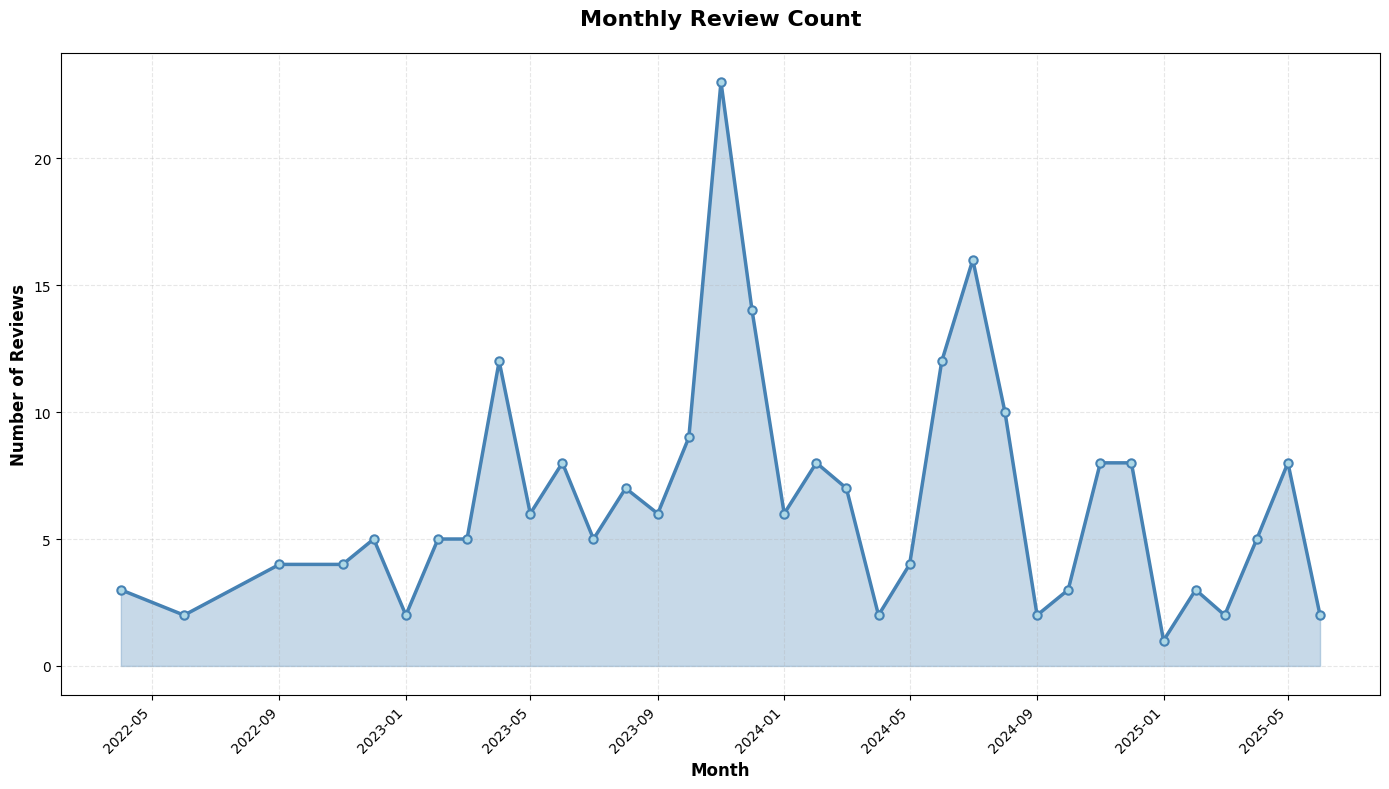


REVIEW ANALYSIS SUMMARY
Total reviews: 227
Review period: April 2022 to June 2025
Average reviews per month: 6.5
Peak month: November 2023 (23 reviews)
Lowest month: January 2025 (1 reviews)
Reviews from 01-01-2025 onwards: 21
Ratio of 2025 reviews to total: 9.25%
Estimated sale of 2025: 241.0


In [137]:
#estimate sale for product ESQA Goddess Eyeshadow Palette
analyze_monthly_reviews(df_goddess_eyeshadow, total_sale= 2600, review_time_col='fix_review_time', product_name=None)

In [25]:
with open('lzd_detail_review_ESQA_Flawless_Liquid_Concealer_20250610_194655.json', 'r') as file:
    flawless_liquid_concealer = json.load(file)
df_flawless_liquid_concealer = cleaning_all(flawless_liquid_concealer)
min(df_flawless_liquid_concealer.fix_review_time)

datetime.date(2021, 11, 17)

In [ ]:
with open('/Users/leekim/prj/automatedTask/lzd_detail_review_ESQA_Flawless_Liquid_Mini_Concealer_20250610_220311.json', 'r') as file:
    flawless_liquid_mini_concealer = json.load(file)
df_flawless_liquid_mini_concealer = cleaning_all(flawless_liquid_mini_concealer)


datetime.date(2022, 5, 1)

### 1. Estimate the number one seller of ESQA: ESQA Flawless Powder Foundation

In [139]:
with open('lzd_detail_review_ESQA_Flawless_Powder_Foundation_20250610_170231.json', 'r') as file:
    flawless_powder_foundation = json.load(file)
df_flawless_powder_foundation = cleaning_all(flawless_powder_foundation)

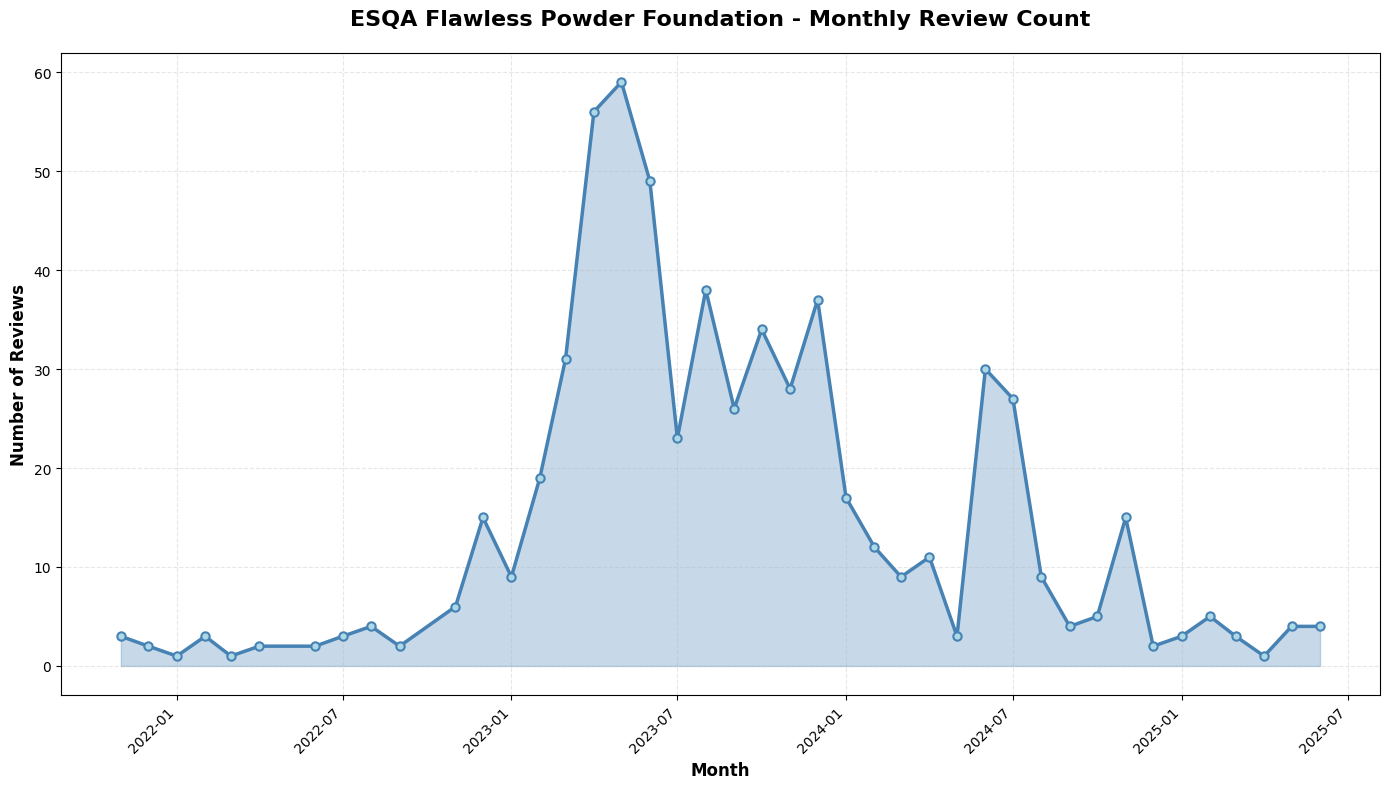


REVIEW ANALYSIS SUMMARY
Total reviews: 617
Review period: November 2021 to June 2025
Average reviews per month: 14.7
Peak month: May 2023 (59 reviews)
Lowest month: January 2022 (1 reviews)
Reviews from 01-01-2025 onwards: 20
Ratio of 2025 reviews to total: 3.24%
Estimated sale of 2025: 259.0


In [140]:
analyze_monthly_reviews(df_flawless_powder_foundation, total_sale= 8000, review_time_col='fix_review_time', product_name='ESQA Flawless Powder Foundation')

### 2. Estimate the number one seller of ESQA: ESQA Flawless Liquid Concealer

In [ ]:
with open('lzd_detail_review_ESQA_Flawless_Liquid_Concealer_20250610_194655.json', 'r') as file:
    flawless_liquid_concealer = json.load(file)
df_flawless_liquid_concealer = cleaning_all(flawless_liquid_concealer)


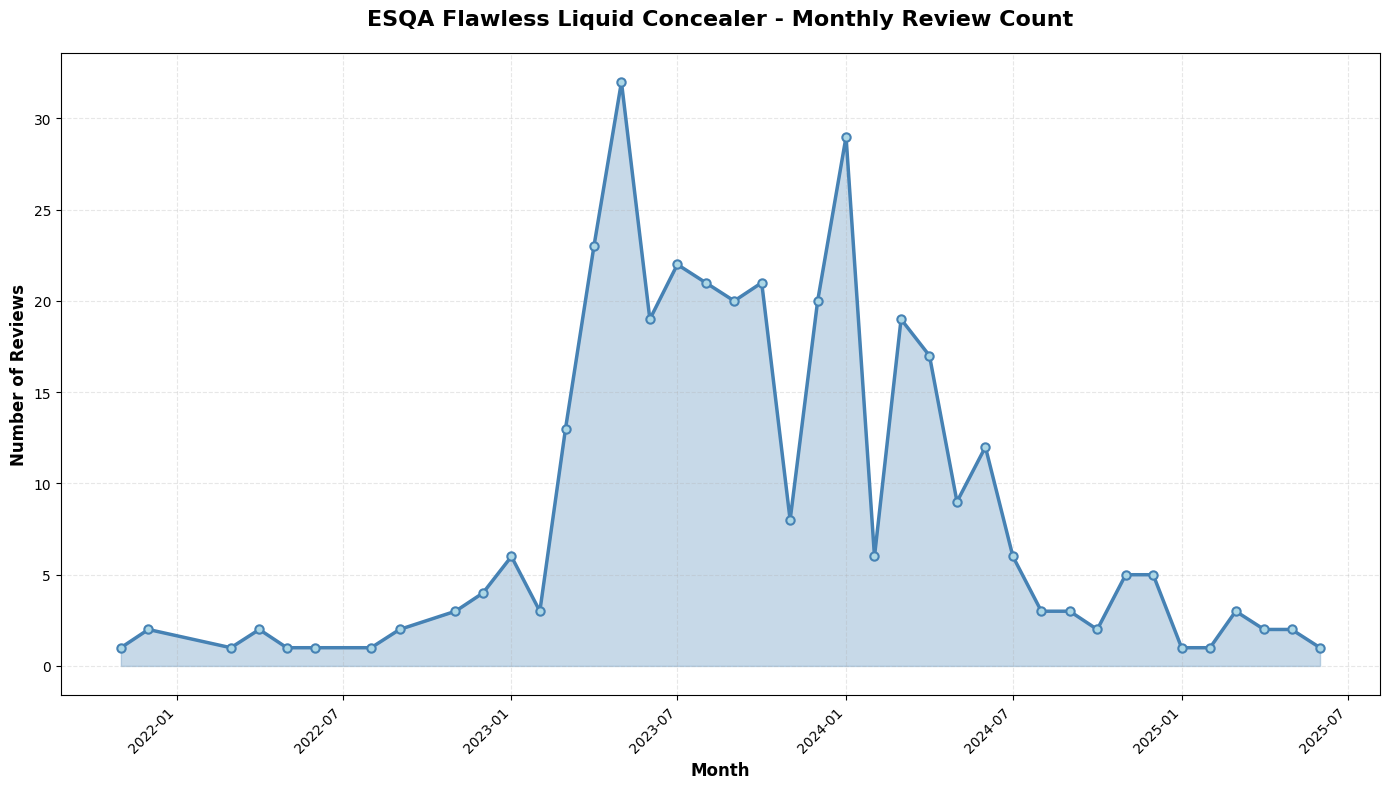


REVIEW ANALYSIS SUMMARY
Total reviews: 352
Review period: November 2021 to June 2025
Average reviews per month: 8.8
Peak month: May 2023 (32 reviews)
Lowest month: November 2021 (1 reviews)
Reviews from 01-01-2025 onwards: 10
Ratio of 2025 reviews to total: 2.84%
Estimated sale of 2025: 210.0


In [143]:
analyze_monthly_reviews(df_flawless_liquid_concealer, total_sale= 7400, review_time_col='fix_review_time', product_name='ESQA Flawless Liquid Concealer')

### 3. Estimate the number one seller of ESQA: ESQA Flawless Liquid Mini Concealer

In [141]:
with open('/Users/leekim/prj/automatedTask/lzd_detail_review_ESQA_Flawless_Liquid_Mini_Concealer_20250610_220311.json', 'r') as file:
    flawless_liquid_mini_concealer = json.load(file)
df_flawless_liquid_mini_concealer = cleaning_all(flawless_liquid_mini_concealer)

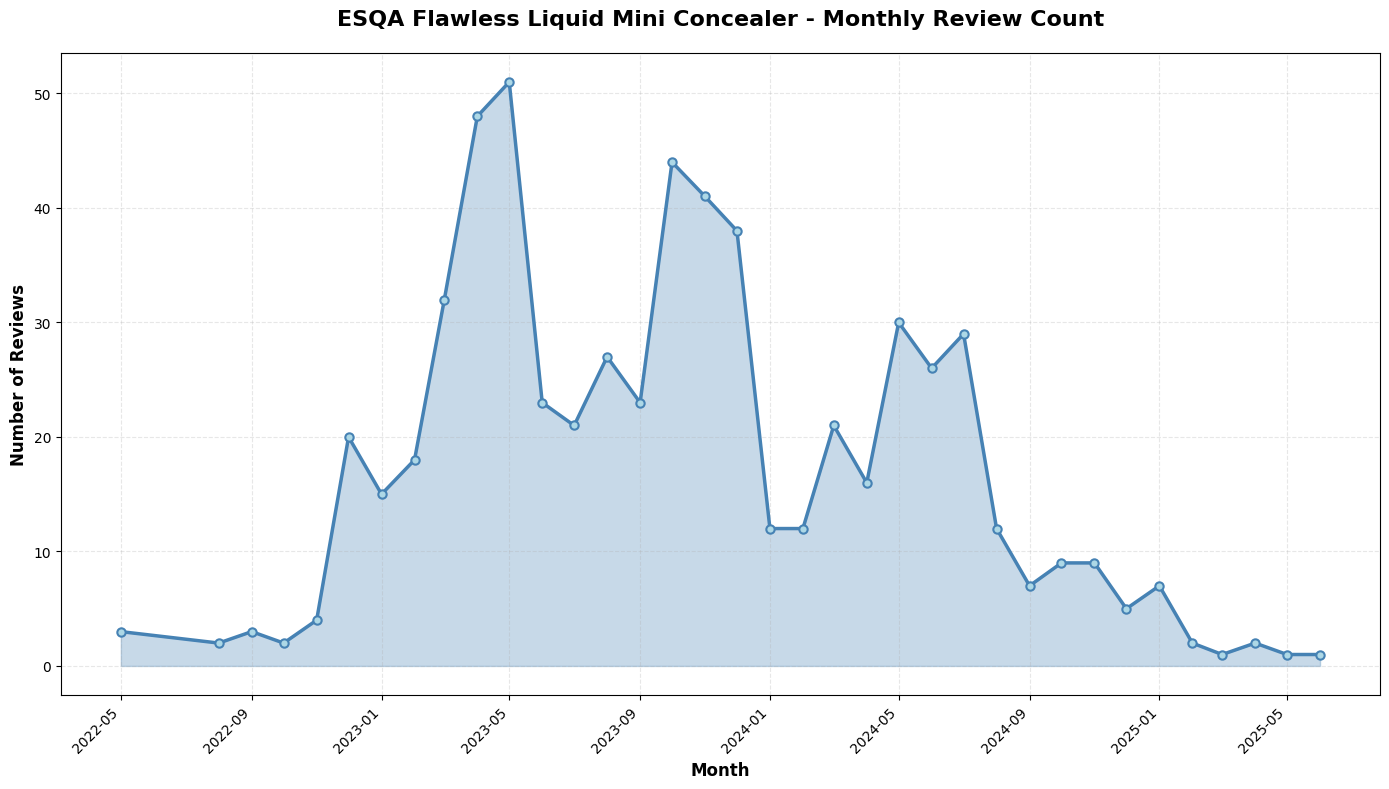


REVIEW ANALYSIS SUMMARY
Total reviews: 617
Review period: May 2022 to June 2025
Average reviews per month: 17.1
Peak month: May 2023 (51 reviews)
Lowest month: March 2025 (1 reviews)
Reviews from 01-01-2025 onwards: 14
Ratio of 2025 reviews to total: 2.27%
Estimated sale of 2025: 147.0


In [144]:
analyze_monthly_reviews(df_flawless_liquid_mini_concealer, total_sale= 6500, review_time_col='fix_review_time', product_name='ESQA Flawless Liquid Mini Concealer')

### 4. Estimate the number one seller of ESQA: ESQA Flawless Liquid Mini Concealer

In [147]:
with open('/Users/leekim/prj/automatedTask/lzd_detail_review_ESQA_Flawless_Cushion_Serum_SPF_50Satin_20250610_133244.json', 'r') as file:
    flawless_cushion_serum = json.load(file)
df_flawless_cushion_serum = cleaning_all(flawless_cushion_serum)

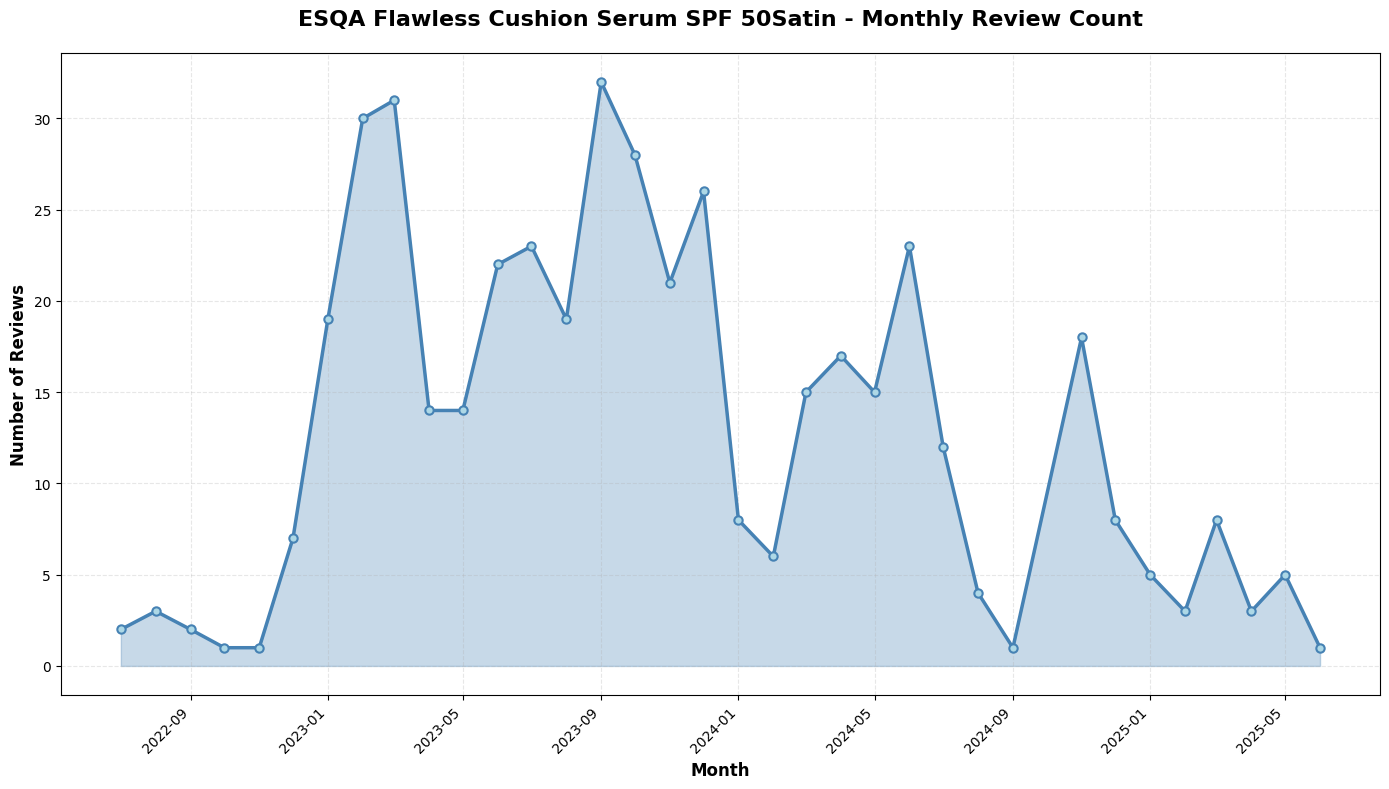


REVIEW ANALYSIS SUMMARY
Total reviews: 447
Review period: July 2022 to June 2025
Average reviews per month: 12.8
Peak month: September 2023 (32 reviews)
Lowest month: October 2022 (1 reviews)
Reviews from 01-01-2025 onwards: 25
Ratio of 2025 reviews to total: 5.59%
Estimated sale of 2025: 257.0


In [148]:
analyze_monthly_reviews(df_flawless_cushion_serum, total_sale= 4600, review_time_col='fix_review_time', product_name='ESQA Flawless Cushion Serum SPF 50Satin')

### 5. Estimate the number one seller of ESQA: ESQA Flawless Setting Powder

In [145]:
with open('lzd_detail_review_ESQA_Flawless_Setting_Powder_20250611_094500.json', 'r') as file:
    flawless_setting_powder = json.load(file)
df_flawless_setting_powder = cleaning_all(flawless_setting_powder)

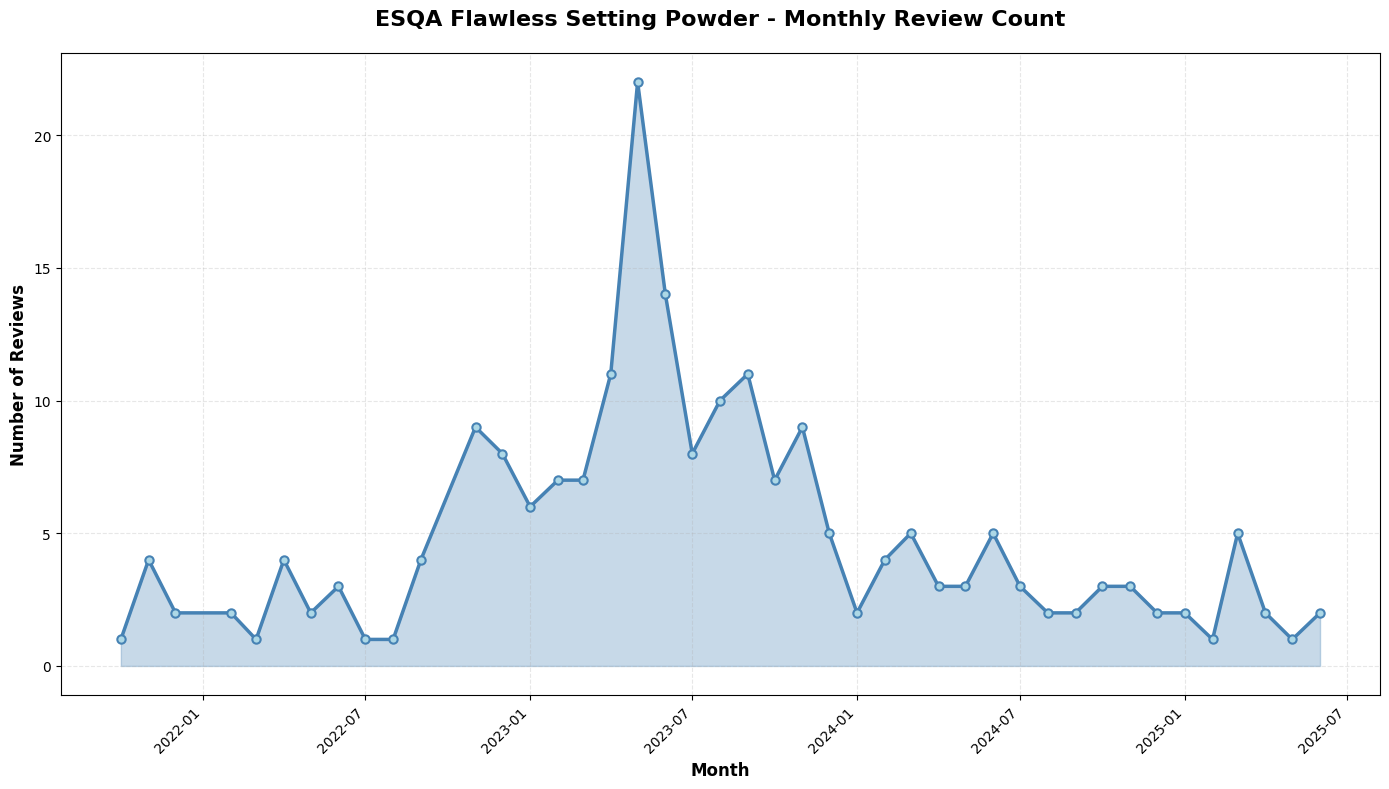


REVIEW ANALYSIS SUMMARY
Total reviews: 209
Review period: October 2021 to June 2025
Average reviews per month: 4.9
Peak month: May 2023 (22 reviews)
Lowest month: October 2021 (1 reviews)
Reviews from 01-01-2025 onwards: 13
Ratio of 2025 reviews to total: 6.22%
Estimated sale of 2025: 174.0


In [146]:
analyze_monthly_reviews(df_flawless_setting_powder, total_sale= 2800, review_time_col='fix_review_time', product_name='ESQA Flawless Setting Powder')